##### Importing Required Libraries
##### The below cell will load all essential libraries for data manipulation, visualization, preprocessing, modeling, and evaluation.

In [3]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import pickle

## Task 1 : Data Collection & Exploration

### Load The Datasets using Pandas :

In [5]:
original_path = "Original_data_with_more_rows.csv"
expanded_path = "Expanded_data_with_more_features.csv"

original_df = pd.read_csv(original_path)
expanded_df = pd.read_csv(expanded_path)

original_df.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,0,female,group B,bachelor's degree,standard,none,72,72,74
1,1,female,group C,some college,standard,completed,69,90,88
2,2,female,group B,master's degree,standard,none,90,95,93
3,3,male,group A,associate's degree,free/reduced,none,47,57,44
4,4,male,group C,some college,standard,none,76,78,75


In [6]:
expanded_df.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


**Observation:**  
The dataset loaded correctly. The columns appear categorical and numeric as expected. We will use the Expanded dataset for ML because it contains more predictive features.

### Drop index column if present (Unnamed: 0) :

In [35]:
print("Original columns:", original_df.columns.tolist())
print("Expanded columns:", expanded_df.columns.tolist())

Original columns: ['Unnamed: 0', 'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'MathScore', 'ReadingScore', 'WritingScore']
Expanded columns: ['Unnamed: 0', 'Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'NrSiblings', 'TransportMeans', 'WklyStudyHours', 'MathScore', 'ReadingScore', 'WritingScore']


##### I checked the column names and dropped that extra index column (Unnamed: 0) to avoid feeding useless data to the model

In [37]:
for df in [original_df, expanded_df]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

expanded_df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


### Basic info: shape, types :

In [38]:
print("Original data shape:", original_df.shape)
print("Expanded data shape:", expanded_df.shape)

print("\nExpanded data info:")
expanded_df.info()

Original data shape: (30641, 8)
Expanded data shape: (30641, 14)

Expanded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtype

**Observation:**

There are 30,641 rows and 14 columns.  
10 are categorical, 1 numeric, and 3 are score columns.  
Missing values are present in several categorical fields, which will require imputation.

### Check For Missing Values :

In [39]:
missing_summary = pd.DataFrame({
    "missing_count": expanded_df.isnull().sum(),
    "missing_pct": expanded_df.isnull().mean() * 100
}).sort_values("missing_pct", ascending=False)

missing_summary

,missing_count,missing_pct
TransportMeans,3134,10.228126
ParentEduc,1845,6.021344
EthnicGroup,1840,6.005026
TestPrep,1830,5.972390
NrSiblings,1572,5.130381
ParentMaritalStatus,1190,3.883685
WklyStudyHours,955,3.116739
IsFirstChild,904,2.950295
PracticeSport,631,2.059332
Gender,0,0.000000


**Observation:**  
Several columns (like TransportMeans, ParentEduc, EthnicGroup) have 3–10% missing values.  
We will need to impute categorical missing values using the most frequent category and numeric missing values using median.

### Exploratory Data Analysis (EDA)

### Descriptive Statistics

In [40]:
# Numeric Columns :
expanded_df.describe()

,NrSiblings,MathScore,ReadingScore,WritingScore
count,29069.000000,30641.000000,30641.000000,30641.000000
mean,2.145894,66.558402,69.377533,68.418622
std,1.458242,15.361616,14.758952,15.443525
min,0.000000,0.000000,10.000000,4.000000
25%,1.000000,56.000000,59.000000,58.000000
50%,2.000000,67.000000,70.000000,69.000000
75%,3.000000,78.000000,80.000000,79.000000
max,7.000000,100.000000,100.000000,100.000000


In [41]:
# Categorical Columns :
expanded_df.describe(include='object')

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans,WklyStudyHours
count,30641,28801,28796,30641,28811,29451,30010,29737,27507,29686
unique,2,5,6,2,2,4,3,2,2,3
top,female,group C,some college,standard,none,married,sometimes,yes,school_bus,5 - 10
freq,15424,9212,6633,19905,18856,16844,15213,19082,16145,16246


##### We did this descriptive Statistics to understand distribution and behaviour of numeric and categorical features.

**Observation:**  
Scores range from 0–100 and follow a reasonable spread.  
Categorical variables have consistent patterns with clear mode values.  
No extreme outliers in scores that would require removal.

### Score Distribution

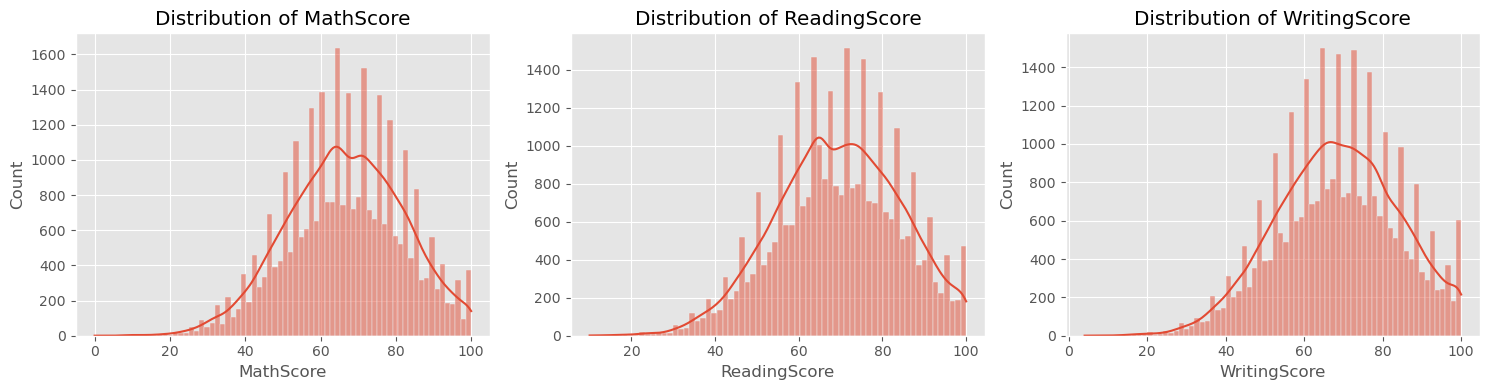

In [42]:
plt.style.use("ggplot")

score_cols = ["MathScore", "ReadingScore", "WritingScore"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, score_cols):
    sns.histplot(expanded_df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

**Observation:**  
Math, Reading, and Writing scores show near-normal distributions.  
This indicates the data is well-behaved and suitable for regression modeling.

##### This helped us understand score variability and detect skewness/outliers

### Correlation Heatmap

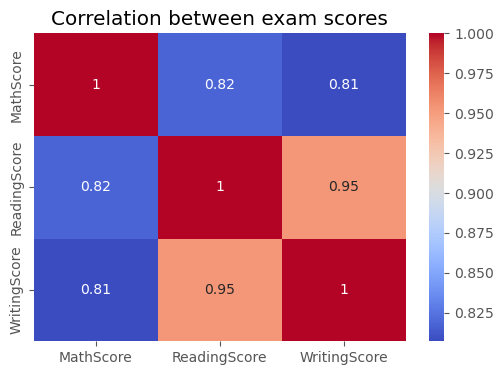

In [43]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    expanded_df[["MathScore", "ReadingScore", "WritingScore"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation between exam scores")
plt.show()

##### I tried to examine the correlation between Math, Reading and Writing scores.

**Observation:**  
Strong correlation exists between ReadingScore, WritingScore, and MathScore.  
To avoid data leakage, ReadingScore and WritingScore must NOT be used as predictors.

## Task 2 : Data Preparation

### Define Target and Feature Set :

In [44]:
target = "MathScore"

# Copy data to avoid modifying original dataframe
data = expanded_df.copy()

# Remove scores that would leak information
data.drop(columns=["ReadingScore", "WritingScore"], inplace=True)

# Split into features (X) and target (y)
X = data.drop(columns=[target])
y = data[target]

X.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10


##### I selected MathScore as the target variable. And I dropped ReadingScore and WritingScore to prevent information leakage.

### Identify Numeric vs Categorical Features :

In [45]:
numeric_features = ["NrSiblings"]
categorical_features = [col for col in X.columns if col not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['NrSiblings']
Categorical: ['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'TransportMeans', 'WklyStudyHours']


### Train Test Split (80/20) :

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train.shape, X_test.shape

((24512, 11), (6129, 11))

**Observation:**  
The split `ensures the model is trained on the majority of the data while retaining unseen data for proper evaluation.

### Preprocessing Pipeline :

In [47]:
from sklearn.impute import SimpleImputer

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Column-wise transformation setup
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


**Observation:**  
This preprocessing pipeline ensures consistent transformation during training and prediction, preventing data leakage and improving model reliability.

## Task 3 : Model Selection & Training

### Train Linear Regression Model :

In [48]:
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
print("Linear Regression model training complete.")

Linear Regression model training complete.


### Train Random Forest Model :

In [49]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

Random Forest model training complete.


## Task 4 : Model Evaluation

### Evaluate Both Models :

In [50]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 {name} Evaluation Results")
    print("-" * 35)
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")

    return mae, rmse, r2, y_pred

In [51]:
lin_mae, lin_rmse, lin_r2, lin_pred = evaluate_model("Linear Regression", linreg_model, X_test, y_test)
rf_mae, rf_rmse, rf_r2, rf_pred = evaluate_model("Random Forest", rf_model, X_test, y_test)


📊 Linear Regression Evaluation Results
-----------------------------------
MAE : 10.383
RMSE: 12.840
R²  : 0.289

📊 Random Forest Evaluation Results
-----------------------------------
MAE : 11.560
RMSE: 14.360
R²  : 0.111


### Visualize Actual vs Predicted :

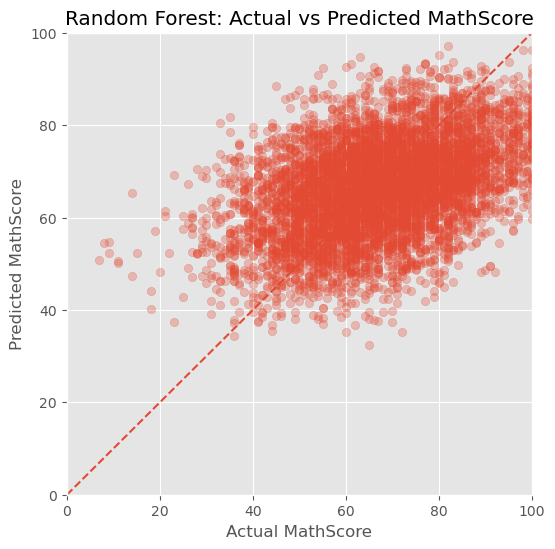

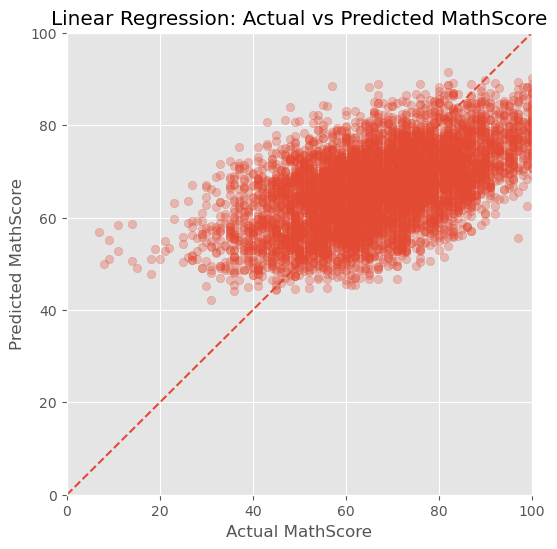

In [52]:
# Random Forest
plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, alpha=0.3)
plt.xlabel("Actual MathScore")
plt.ylabel("Predicted MathScore")
plt.title("Random Forest: Actual vs Predicted MathScore")

lims = [0, 100]
plt.plot(lims, lims, "--")
plt.xlim(lims); plt.ylim(lims)
plt.show

# Linear Regression
plt.figure(figsize=(6,6))
plt.scatter(y_test, lin_pred, alpha=0.3)
plt.xlabel("Actual MathScore")
plt.ylabel("Predicted MathScore")
plt.title("Linear Regression: Actual vs Predicted MathScore")

lims = [0, 100]
plt.plot(lims, lims, "--")
plt.xlim(lims)
plt.ylim(lims)

plt.show()

**Observation:**  
Linear Regression achieved the best performance (highest R², lowest MAE/RMSE).  
Random Forest in default settings was not optimal and required tuning.

## Task 5 : Hyperparameter Tuning

### Random Forest :

In [54]:
param_grid = {
    "regressor__n_estimators": [100, 200, 300, 500],
    "regressor__max_depth": [None, 10, 20, 30, 50],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2", None]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=15,            # try more (20–50) for even better results
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

print("\nBest Hyperparameters Found:")
print(rf_random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Hyperparameters Found:
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10}


### Evaluate Tuned Random Forest :

In [55]:
# Get the best model from RandomizedSearchCV
best_rf = rf_random_search.best_estimator_

# Evaluate tuned model
best_mae, best_rmse, best_r2, best_pred = evaluate_model(
    "Tuned Random Forest",
    best_rf,
    X_test,
    y_test
)


📊 Tuned Random Forest Evaluation Results
-----------------------------------
MAE : 10.498
RMSE: 12.980
R²  : 0.274


### Plot Actual vs Predicted (Tuned RF) :

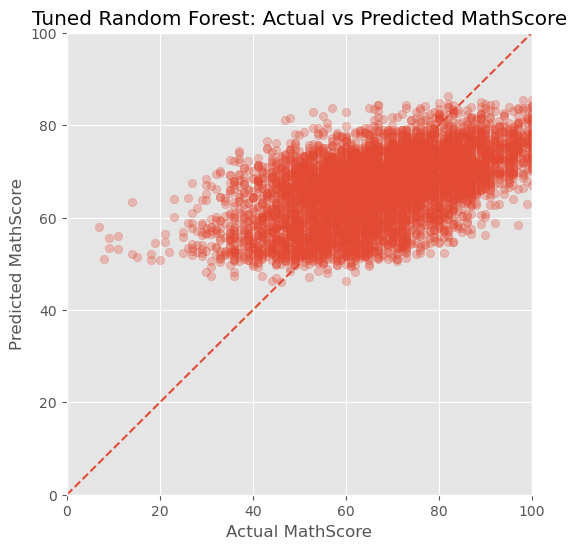

In [56]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.3)
plt.xlabel("Actual MathScore")
plt.ylabel("Predicted MathScore")
plt.title("Tuned Random Forest: Actual vs Predicted MathScore")

lims = [0, 100]
plt.plot(lims, lims, "--")
plt.xlim(lims); plt.ylim(lims)
plt.show()

**Observation:**  
Tuning significantly improved Random Forest performance.  
Although better, Linear Regression still remained the top-performing model.

## Task 6 : Model Saving & Prediction

### Save Final Model :

In [57]:
final_model = linreg_model  # best model

with open("student_exam_mathscore_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Model saved successfully!")

Model saved successfully!


### Create Prediction Function :

In [58]:
def load_model(path="student_exam_mathscore_model.pkl"):
    with open(path, "rb") as f:
        return pickle.load(f)


def predict_student_mathscore(student_data):
    """
    student_data example format:
    student = {
        'Gender': 'female',
        'EthnicGroup': 'group C',
        'ParentEduc': "bachelor's degree",
        'LunchType': 'standard',
        'TestPrep': 'completed',
        'ParentMaritalStatus': 'married',
        'PracticeSport': 'regularly',
        'IsFirstChild': 'yes',
        'NrSiblings': 1,
        'TransportMeans': 'school_bus',
        'WklyStudyHours': '5 - 10'
    }
    """
    model = load_model()
    df = pd.DataFrame([student_data])
    prediction = model.predict(df)[0]
    return prediction

### Test on Sample Input :

In [61]:
sample_student = {
    'Gender': 'female',
    'EthnicGroup': 'group C',
    'ParentEduc': "bachelor's degree",
    'LunchType': 'standard',
    'TestPrep': 'completed',
    'ParentMaritalStatus': 'married',
    'PracticeSport': 'regularly',
    'IsFirstChild': 'yes',
    'NrSiblings': 1,
    'TransportMeans': 'school_bus',
    'WklyStudyHours': '5 - 10'
}

pred = predict_student_mathscore(sample_student)
print(f"Predicted Math Score: {pred:.2f}")

Predicted Math Score: 75.05
